In [149]:
%matplotlib inline
import numpy as np
import random as rnd
import scipy
import scipy.linalg
import random
import matplotlib.pyplot as plt
from datetime import date
from math import sqrt, log, exp
from scipy import stats, linalg, interpolate

## Parameters of Option
# 0 : switch off / 1: switchon
PlotFlag = 1;

# 0 : Call Option / 1: Put Option
Type = 0;

BasedYears = 365
DayCount = (date(2017,2,12).toordinal() - date(2016,11,10).toordinal())
Tau = DayCount/BasedYears
Spot = 250
Strike = 250
Rate = 0.01
Dividend = 0.01
Volatility = 0.2

In [150]:
## Black-Scholes (Closed form).
d1 = (log(Spot/Strike) + ((Rate - Dividend) + Volatility**2 /2)*Tau) / (Volatility * sqrt(Tau))
d2 = d1 - (Volatility * sqrt(Tau))

if Type == 0:
    BLSPrice = Spot * stats.norm.cdf(d1) - Strike * (exp(-(Rate - Dividend)* Tau) * stats.norm.cdf(d2))
elif Type == 1:
    BLSPrice = Strike * (exp(-(Rate - Dividend)* Tau) * stats.norm.cdf(-d2)) - Spot * stats.norm.cdf(-d1)
print("\n\n\n")
print("Pricing - BLS Closed-form           : %10.5f"  %BLSPrice)





Pricing - BLS Closed-form           :   10.11838


In [151]:
################################# MC Simulation Set ######################################
random.seed(0)
NumOfSimulation = 50000

## Black-Scholes (MC Simulation).
RandomSample = np.random.randn(NumOfSimulation, DayCount)
S_path = Spot * np.cumprod(np.exp((Rate-Dividend - 0.5 * Volatility**2)/BasedYears + Volatility * sqrt(1/BasedYears) * RandomSample), axis = 1)

if Type == 0:
    Payoff_Set = np.maximum(S_path[:,DayCount - 1] - Strike * (exp(-(Rate - Dividend)* Tau)), 0)
elif Type == 1:
    Payoff_Set = np.maximum(Strike * (exp(-(Rate - Dividend)* Tau)) - S_path[:,DayCount - 1], 0)

MCPrice = np.mean(Payoff_Set)*exp(-(Rate-Dividend)*Tau)
MCPriceStdErr = stats.sem(Payoff_Set)
print("Pricing - Monte Carlo   Simulation  : %10.5f / Price diff = %0.5f / StdErr = %0.5f" %(MCPrice, abs(BLSPrice-MCPrice),MCPriceStdErr));

Pricing - Monte Carlo   Simulation  :   10.10756 / Price diff = 0.01082 / StdErr = 0.07037


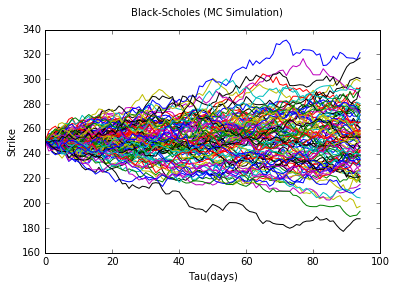

In [152]:
fig=plt.figure(1)
fig.suptitle('Black-Scholes (MC Simulation)')
plt.xlabel('Tau(days)')
plt.ylabel('Strike')
PlotPath = np.c_[np.tile(Spot,[NumOfSimulation, 1]), S_path]
for i in np.arange(0,100):
    plt.hold(True)
    plt.plot(PlotPath[i,:]);

In [155]:
## Black-Scholes (MC Simulation using Antithetic variates). more stable
S_path = Spot*np.cumprod(np.exp((Rate - Dividend - 0.5 * Volatility**2)/BasedYears + Volatility * sqrt(1/BasedYears) * RandomSample), axis = 1)
S_path_anti = Spot*np.cumprod(np.exp((Rate - Dividend - 0.5*Volatility**2)/BasedYears - Volatility*sqrt(1/BasedYears)*RandomSample), axis = 1)

if Type == 0:
    Payoff_Set = np.maximum((S_path[:,DayCount - 1] - Strike), 0)
    Payoff_Set_anti = np.maximum((S_path_anti[:,DayCount - 1] - Strike), 0)
elif Type == 1:
    Payoff_Set = np.maximum((Strike * (exp(-(Rate - Dividend)* Tau))- S_path[:,DayCount - 1]), 0)
    Payoff_Set_anti = np.maximum((Strike * (exp(-(Rate - Dividend)* Tau))- S_path_anti[:,DayCount - 1]), 0)

Price1 = np.mean(Payoff_Set)*exp(-(Rate-Dividend)*Tau)
Price2 = np.mean(Payoff_Set_anti)*exp(-(Rate-Dividend)*Tau)
MCPriceStdErr1 = stats.sem(Payoff_Set)
MCPriceStdErr2 = stats.sem(Payoff_Set_anti)

MCAPrice = 0.5*(Price1+Price2)
MCAPriceStdErr = 0.5*(MCPriceStdErr1+MCPriceStdErr2)
print("Pricing - MC(Antitheric)Simulation  : %10.5f / Price diff = %0.5f / StdErr = %0.5f" %(MCAPrice, abs(BLSPrice-MCAPrice),MCAPriceStdErr));

Pricing - MC(Antitheric)Simulation  :   10.12559 / Price diff = 0.00720 / StdErr = 0.07038


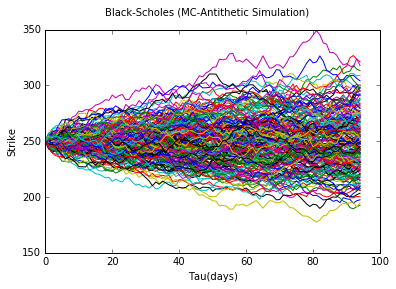

In [129]:
fig=plt.figure(2)
fig.suptitle('Black-Scholes (MC-Antithetic Simulation)')
plt.xlabel('Tau(days)')
plt.ylabel('Strike')
PlotPath1 = np.c_[np.tile(Spot,[NumOfSimulation, 1]), S_path]
PlotPath2 = np.c_[np.tile(Spot,[NumOfSimulation, 1]), S_path_anti]
for i in np.arange(0,100):
    plt.hold(True)
    plt.plot(PlotPath1[i,:])
    plt.plot(PlotPath2[i,:])

In [130]:
################################# FDM Simulation Set ######################################
# Parameters of FDM.
NumOfTGrid = 200
NumOfSGrid = 200
Smax = 5 * Spot
Tmax = DayCount / BasedYears
StrikesGrid = np.linspace(0, Smax, NumOfSGrid)
Tau = np.linspace(0, Tmax, NumOfTGrid)
dt = Tau[1] - Tau[0]
dS = StrikesGrid[1] - StrikesGrid[0]

In [131]:
## Black-Scholes (explicit FDM Simulation).
if Type == 0:
    payoff = np.zeros((NumOfSGrid, NumOfTGrid))
    payoff[:,NumOfTGrid - 1] = np.maximum(StrikesGrid - Strike, 0)
    payoff[NumOfSGrid - 1,:] = (StrikesGrid[NumOfSGrid - 1] - Strike) * np.exp(-(Rate-Dividend) * Tau)
    payoff[1,:] = 0
elif Type == 1:
    payoff = np.zeros((NumOfSGrid, NumOfTGrid))
    payoff[:,NumOfTGrid - 1] = np.maximum(Strike - StrikesGrid, 0)
    payoff[NumOfSGrid - 1,:] = 0
    payoff[1,:] = (Strike - StrikesGrid[NumOfSGrid - 1]) * np.exp(-(Rate-Dividend) * Tau)
    
a = 0.5 * dt * (Volatility**2 * StrikesGrid/(dS**2) - (Rate - Dividend)/dS)* StrikesGrid
b = 1 - dt * (Volatility**2 * StrikesGrid**2/(dS**2) + (Rate - Dividend))
c = 0.5 * dt * (Volatility**2 * StrikesGrid/(dS**2) + (Rate - Dividend)/dS)* StrikesGrid

for j in range(NumOfTGrid - 2, 0, -1) :
    for i in range(1, NumOfSGrid - 2) :
        payoff[i,j] = a[i]*payoff[i-1, j+1] + b[i]*payoff[i, j+1] + c[i]*payoff[i+1, j+1]

expFDMPrice = interpolate.interp1d(StrikesGrid, payoff[:,1])(Spot)
print("Pricing - FDM(Explicit) Simulation  : %10.5f / Price diff = %0.5f" %(expFDMPrice, abs(BLSPrice-expFDMPrice)))

Pricing - FDM(Explicit) Simulation  :   10.12186 / Price diff = 0.00348


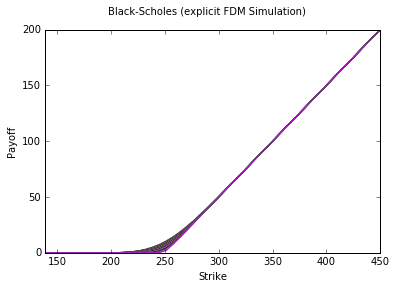

In [132]:
fig=plt.figure(3)
fig.suptitle('Black-Scholes (explicit FDM Simulation)')
plt.xlabel('Strike')
plt.ylabel('Payoff')
for i in np.arange(0,NumOfTGrid,5):
    plt.hold(True)
    plt.plot(StrikesGrid,payoff[:,i])
    plt.xlim(Spot/1.8, 1.8*Spot)
    plt.ylim(0,Spot*0.8)

In [138]:
## Black-Scholes (implicit FDM Simulation).
if Type == 0:
    payoff = np.zeros((NumOfSGrid, NumOfTGrid))
    payoff[:,NumOfTGrid - 1] = np.maximum(StrikesGrid - Strike, 0)
    payoff[NumOfSGrid - 1,:] = (StrikesGrid[NumOfSGrid - 1] - Strike) * np.exp(-(Rate-Dividend) * Tau)
    payoff[1,:] = 0
elif Type == 1:
    payoff = np.zeros((NumOfSGrid, NumOfTGrid))
    payoff[:,NumOfTGrid - 1] = np.maximum(Strike  - StrikesGrid, 0)
    payoff[NumOfSGrid - 1,:] = 0
    payoff[1,:] = (Strike - StrikesGrid[NumOfSGrid - 1]) * np.exp(-(Rate-Dividend) * Tau)
    
a = 0.5 * dt*((Rate - Dividend)/dS - Volatility**2 * StrikesGrid/(dS**2)) * StrikesGrid
b = 1 + dt * (Volatility**2 * StrikesGrid**2/(dS**2) + (Rate - Dividend))
c = - 0.5 * dt*((Rate - Dividend)/dS + Volatility**2 * StrikesGrid/(dS**2)) * StrikesGrid

coeff = np.diag(a[2:NumOfSGrid],-1) + np.diag(b[1:NumOfSGrid]) + np.diag(c[1:NumOfSGrid-1],1)
P, L, U = scipy.linalg.lu(coeff)
Boundary = np.zeros((NumOfSGrid - 1,1))

for j in range(NumOfTGrid - 2, 0, -1) :
    Boundary[0] = - a[2] * payoff[1,j]
    payoff[1:NumOfSGrid, j:j+1] = (linalg.inv(U).dot(linalg.inv(L).dot(payoff[1:NumOfSGrid, (j + 1):(j + 2)] + Boundary)))

impFDMPrice = interpolate.interp1d(StrikesGrid, payoff[:,1])(Spot)
print("Pricing - FDM(Implicit) Simulation  : %10.5f / Price diff = %0.5f" %(impFDMPrice, abs(BLSPrice-impFDMPrice)))

Pricing - FDM(Implicit) Simulation  :   10.10918 / Price diff = 0.00920


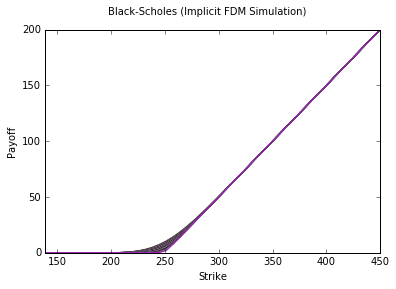

In [134]:
fig=plt.figure(4)
fig.suptitle('Black-Scholes (Implicit FDM Simulation)')
plt.xlabel('Strike')
plt.ylabel('Payoff')
for i in np.arange(0,NumOfTGrid,5):
    plt.hold(True)
    plt.plot(StrikesGrid,payoff[:,i])
    plt.xlim(Spot/1.8, 1.8*Spot)
    plt.ylim(0,Spot*0.8)

In [135]:
## Black-Scholes (C-N FDM Simulation).
if Type == 0:
    payoff = np.zeros((NumOfSGrid, NumOfTGrid))
    payoff[:,NumOfTGrid - 1] = np.maximum(StrikesGrid - Strike, 0)
    payoff[NumOfSGrid - 1,:] = (StrikesGrid[NumOfSGrid - 1] - Strike) * np.exp(-(Rate-Dividend) * Tau)
    payoff[1,:] = 0
elif Type == 1:
    payoff = np.zeros((NumOfSGrid, NumOfTGrid))
    payoff[:,NumOfTGrid - 1] = np.maximum(Strike - StrikesGrid, 0)
    payoff[NumOfSGrid - 1,:] = 0
    payoff[1,:] = (Strike - StrikesGrid[NumOfSGrid - 1]) * np.exp(-(Rate-Dividend) * Tau)
    
a = 0.25*dt*( -(Rate - Dividend)/dS + (Volatility**2) * StrikesGrid/dS**2)*StrikesGrid
b = -0.5*dt*((Volatility**2) * (StrikesGrid**2)/(dS**2) + (Rate - Dividend))
c = 0.25*dt*((Rate - Dividend)/dS + (Volatility**2) * StrikesGrid/dS**2)*StrikesGrid

coeff = -np.diag(a[2:NumOfSGrid],-1) + np.diag(1 - b[1:NumOfSGrid]) - np.diag(c[1:NumOfSGrid-1],1)
P, L, U = scipy.linalg.lu(coeff)
D = np.diag(a[2:NumOfSGrid],-1) + np.diag(1 + b[1:NumOfSGrid]) + np.diag(c[1:NumOfSGrid-1],1)
Boundary = np.zeros((NumOfSGrid - 1,1))

for j in range(NumOfTGrid - 2, 0, -1) :
    Boundary[0] = a[1] * (payoff[0,j] + payoff[0,j+1]);
    Boundary[NumOfSGrid - 2] = c[NumOfSGrid - 1] * (payoff[NumOfSGrid - 1,j] + payoff[NumOfSGrid - 1,j+1]);
    payoff[1:NumOfSGrid, j:j+1]= linalg.inv(U).dot(linalg.inv(L).dot(D.dot(payoff[1:NumOfSGrid, (j + 1):(j + 2)] + Boundary)));

CNFDMPrice = interpolate.interp1d(StrikesGrid, payoff[:,1])(Spot)
print("Pricing - FDM(C - N)    Simulation  : %10.5f / Price diff = %0.5f" %(CNFDMPrice, abs(BLSPrice-CNFDMPrice)))

Pricing - FDM(C - N)    Simulation  :   10.11553 / Price diff = 0.00286


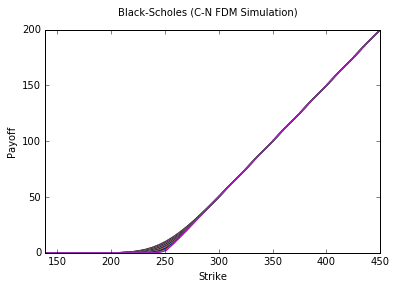

In [136]:
fig=plt.figure(5)
fig.suptitle('Black-Scholes (C-N FDM Simulation)')
plt.xlabel('Strike')
plt.ylabel('Payoff')
for i in np.arange(0,NumOfTGrid,5):
    plt.hold(True)
    plt.plot(StrikesGrid,payoff[:,i])
    plt.xlim(Spot/1.8, 1.8*Spot)
    plt.ylim(0,Spot*0.8)